# Year Sales Analysis

---

Importing necessary libraries

In [284]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

---

### 1. Merging 12 month data into one CSV file

In [285]:
files = [file for file in os.listdir(r'Sales_Data') if not file.startswith('.')] # Ignoring hidden files
all_data = pd.DataFrame()

for file in files:
    month_data = pd.read_csv('Sales_Data\\'+file)
    all_data = pd.concat([all_data, month_data])
    
all_data.to_csv('All_Data\\all_data.csv', index=False)

Reading all data from new DataFrame

In [286]:
all_month_data = pd.read_csv(r'All_Data\all_data.csv')
all_month_data.head(10)

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"
6,176562,USB-C Charging Cable,1,11.95,04/29/19 13:03,"381 Wilson St, San Francisco, CA 94016"
7,176563,Bose SoundSport Headphones,1,99.99,04/02/19 07:46,"668 Center St, Seattle, WA 98101"
8,176564,USB-C Charging Cable,1,11.95,04/12/19 10:58,"790 Ridge St, Atlanta, GA 30301"
9,176565,Macbook Pro Laptop,1,1700,04/24/19 10:38,"915 Willow St, San Francisco, CA 94016"


---

### 2. Cleaning up data

- Droping NaN values

In [287]:
all_month_data = all_month_data.dropna(how='all')

- Removing values like 'Order Date' in order date column

In [289]:
all_month_data = all_month_data[all_month_data['Month'] != 'Or']

- Correcting Data types

In [291]:
all_month_data['Quantity Ordered'] = pd.to_numeric(all_month_data['Quantity Ordered']) # to int
all_month_data['Price Each'] = pd.to_numeric(all_month_data['Price Each']) # to float

In [292]:
all_month_data['Order Date'] = pd.to_datetime(all_month_data['Order Date'])

C:\Users\elkfrawy\AppData\Local\Temp\ipykernel_3232\2369060954.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_month_data['Order Date'] = pd.to_datetime(all_month_data['Order Date'])


---

### 3. Augmenting Data with new columns

- Month column for better filtering

In [290]:
all_month_data['Month'] = all_month_data['Order Date'].str[0:2]
all_month_data['Month'] = all_month_data['Month'].astype('int32')

- Sales column

In [293]:
all_month_data['Sales'] = all_month_data['Quantity Ordered'] * all_month_data['Price Each']

- City column

In [294]:
# By apply method we extract the city from the purchase address
def get_city(x):
    return x.split(',')[1].strip()

- ***Since multiple state can cause duplicates in cities we may need to extract the state from the addrees too***

In [295]:
def get_state(x):
    return x.split(',')[2].split(' ')[1]

In [296]:
# Now joining the two texts in city column
all_month_data['City'] = all_month_data['Purchase Address'].apply(lambda x: f"{get_city(x)} ({get_state(x)})")

- Time colums

In [297]:
all_month_data['Hour'] = all_month_data['Order Date'].dt.hour
all_month_data['Minute'] = all_month_data['Order Date'].dt.minute

## Questions ???

#### 1. What was the best month for sales? How much was earned that month?

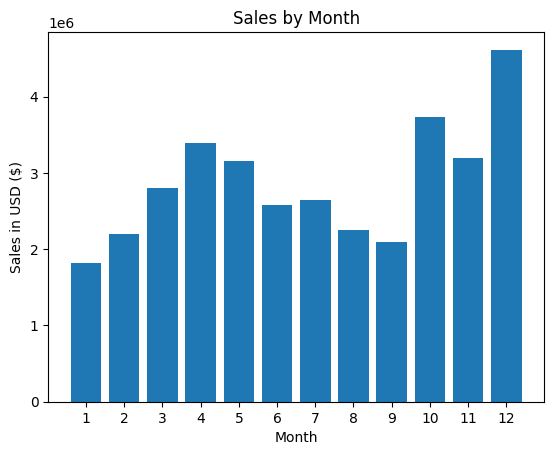

In [298]:
results = all_month_data[['Month', 'Sales']].groupby('Month').sum()

plt.bar(range(1, 13), height=results['Sales'])
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Sales in USD ($)')
plt.title('Sales by Month')
plt.show()

#### 2. What was the city with most sales?

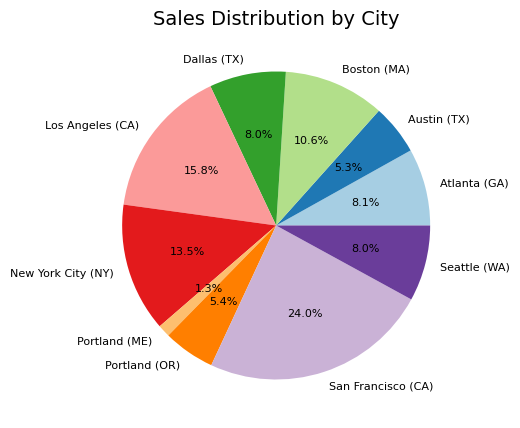

In [299]:
results = all_month_data[['City', 'Sales']].groupby('City').sum()

plt.figure(figsize=(5, 5))
plt.pie(
    results['Sales'], 
    labels=results.index, 
    autopct='%1.1f%%', 
    colors=plt.cm.Paired.colors,  
    textprops={'fontsize': 8}    
)
plt.title('Sales Distribution by City', fontsize=14)
plt.show()

### 3. What is the best time we should display advertisements to increase Sales?

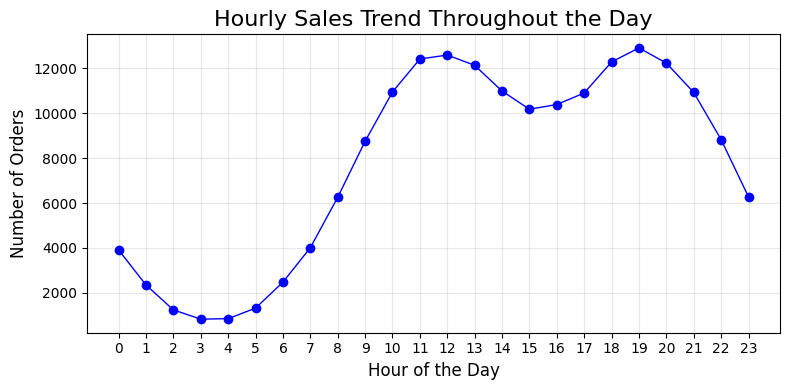

In [300]:
results = all_month_data[['Order ID', 'Hour']].groupby('Hour').count()

plt.figure(figsize=(8, 4))
plt.plot(results.index, results['Order ID'], marker='o', color='b', linestyle='-', linewidth=1)
plt.title('Hourly Sales Trend Throughout the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

### 4. What is the most sold pairs of products (most sold two products together)?

In [301]:
df = all_month_data[all_month_data['Order ID'].duplicated(keep=False)]

df['Products Grouped'] = df.groupby('Order ID').Product.transform(lambda x: ','.join(x))
df2 = df[['Order ID', 'Products Grouped']].drop_duplicates()

C:\Users\elkfrawy\AppData\Local\Temp\ipykernel_3232\1095935202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Products Grouped'] = df.groupby('Order ID').Product.transform(lambda x: ','.join(x))


In [302]:
count = Counter()

for row in df2['Products Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))
    
for key, value in count.most_common(10):
    print('Pair:', key, 'sold ', value, ' Times')

Pair: ('iPhone', 'Lightning Charging Cable') sold  1005  Times
Pair: ('Google Phone', 'USB-C Charging Cable') sold  987  Times
Pair: ('iPhone', 'Wired Headphones') sold  447  Times
Pair: ('Google Phone', 'Wired Headphones') sold  414  Times
Pair: ('Vareebadd Phone', 'USB-C Charging Cable') sold  361  Times
Pair: ('iPhone', 'Apple Airpods Headphones') sold  360  Times
Pair: ('Google Phone', 'Bose SoundSport Headphones') sold  220  Times
Pair: ('USB-C Charging Cable', 'Wired Headphones') sold  160  Times
Pair: ('Vareebadd Phone', 'Wired Headphones') sold  143  Times
Pair: ('Lightning Charging Cable', 'Wired Headphones') sold  92  Times


### 5. What products sold the most? And why?

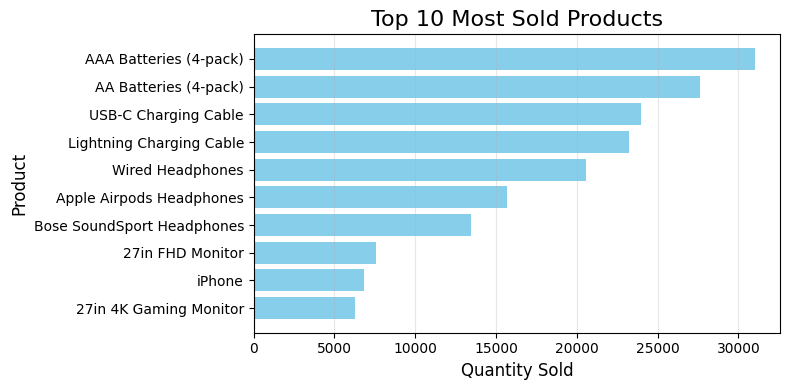

In [303]:
products = all_month_data[['Product', 'Quantity Ordered']].groupby('Product').sum().sort_values(by='Quantity Ordered', ascending=False)

top_products = products.head(10)

plt.figure(figsize=(8, 4))
plt.barh(top_products.index, top_products['Quantity Ordered'], color='skyblue')
plt.xlabel('Quantity Sold', fontsize=12)
plt.ylabel('Product', fontsize=12)
plt.title('Top 10 Most Sold Products', fontsize=16)
plt.gca().invert_yaxis() 
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

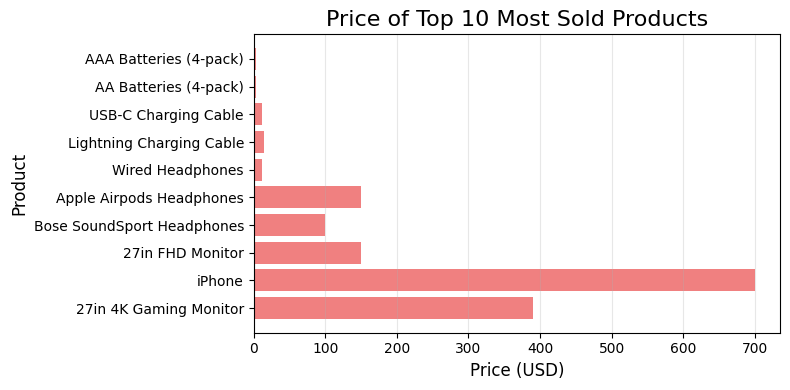

In [304]:
prices = all_month_data[['Product', 'Price Each']].groupby('Product').mean()
top_prices = prices.loc[top_products.index, 'Price Each']

plt.figure(figsize=(8, 4))

plt.barh(top_prices.index, top_prices, color='lightcoral')

plt.xlabel('Price (USD)', fontsize=12)
plt.ylabel('Product', fontsize=12)
plt.title('Price of Top 10 Most Sold Products', fontsize=16)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()